In [1]:
import numpy as np
import pyvisa as visa
import time
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
rm = visa.ResourceManager()

In [3]:
rm.list_resources()

('USB0::0x0699::0x0368::C017067::INSTR', 'ASRL1::INSTR', 'ASRL10::INSTR')

In [4]:
resource_name_o = 'USB0::0x0699::0x0368::C017067::INSTR'

osci = rm.open_resource(resource_name_o)

In [5]:
osci.query('*IDN?')

'TEKTRONIX,TBS 1052B-EDU,C017067,CF:91.1CT FV:v3.25\n'

In [161]:
def saver(name,folder,autoset=True,plot=True):
    time_s = time.time()
    if autoset:
        osci.write('AUTOS exec')
        time.sleep(6)
    osci.write('DAT:SOU CH1')
    xze, xin = osci.query_ascii_values('WFMPRE:XZE?;XIN?', separator=';')
    
    osci.write('ACQ:STATE STOP')
    yze1, ymu1, yoff1 = osci.query_ascii_values('WFMPRE:YZE?;YMU?;YOFF?;', separator=';')
    
    osci.write('DAT:ENC RPB')
    osci.write('DAT:WID 1')
    
    osci.write("DAT:SOU CH1")
    data1 = osci.query_binary_values('CURV?', datatype='B', container=np.array)
    tiempo = xze + np.arange(len(data1)) * xin
    data1v = (data1 - yoff1) * ymu1 + yze1
    
    osci.write('ACQ:STATE RUN')
    
    df = pd.DataFrame({'t':tiempo,'V_R':data1v})
    if plot is not False:
        plt.plot(df.t,df.V_R)
        plt.grid()
        plt.show()
    df.to_csv(f'plots seke/special/{folder}/{name}.csv',index=False)

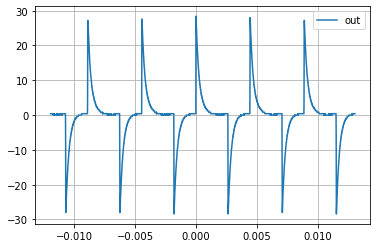

In [39]:
saver('1000','barrido L',autoset=False)

In [104]:
from scipy.signal import find_peaks as pk
import os
from scipy.optimize import curve_fit as cf
lineal = lambda x,a,b : a*x+b

def r2(y,x,lineal,pars):
    r2 = 1 - (np.sum((y-lineal(x,*pars))**2)/np.sum((y-np.mean(y))**2))
    return r2

def chi2_red(y,y_err,x,func,popt):
    puntos = len(y)
    params = len(popt)
    grados_lib = puntos - params - 1
    y_ajuste = func(x,*popt)
    
    chi_cuadrado = np.sum(((y-y_ajuste)/y_err)**2)
    chi_reducido = chi_cuadrado/grados_lib
    return chi_reducido

In [55]:
files = os.listdir('plots seke/special/barrido L')

names = []
for i in range(len(files)):
    if files[i].endswith('.csv'):
        names.append(int(files[i][:-4]))
names = np.array(names)

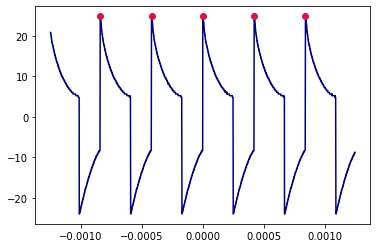

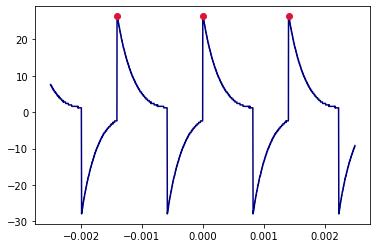

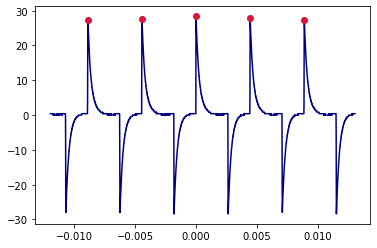

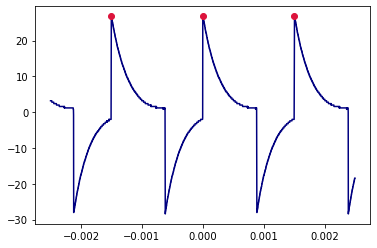

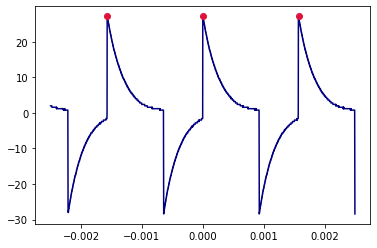

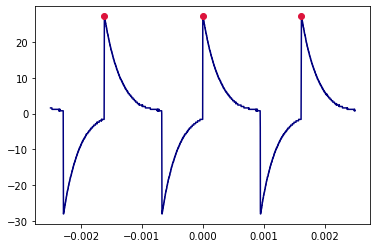

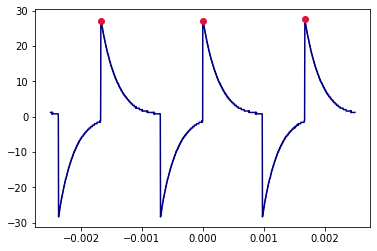

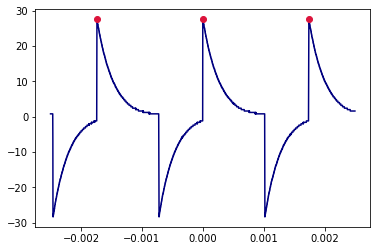

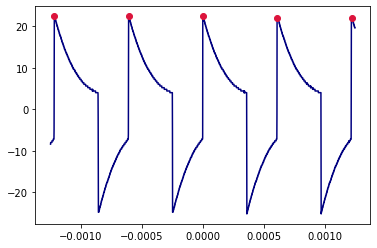

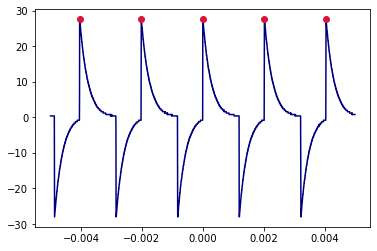

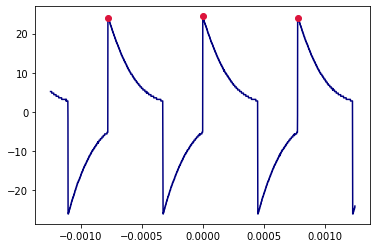

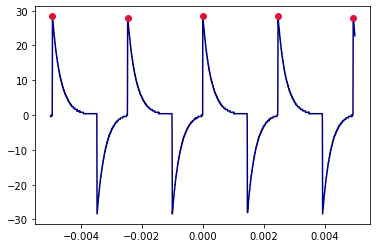

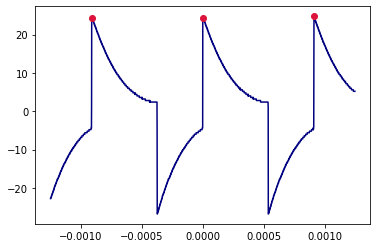

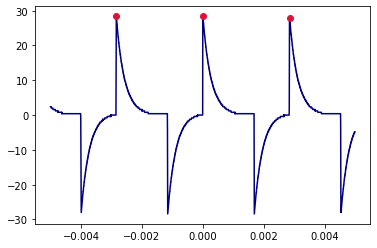

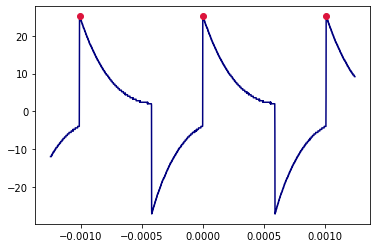

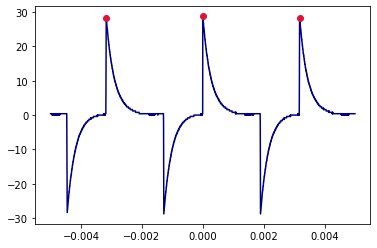

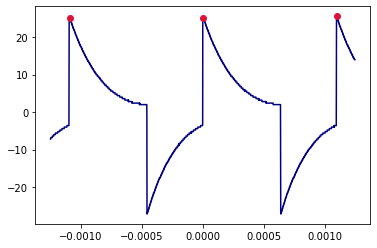

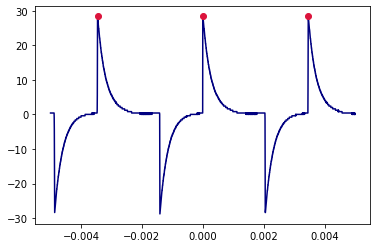

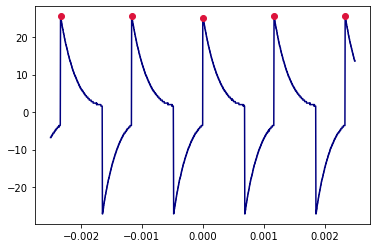

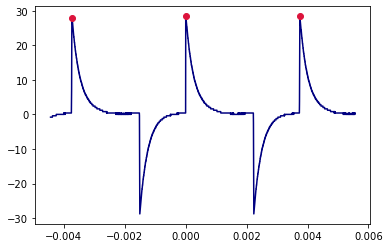

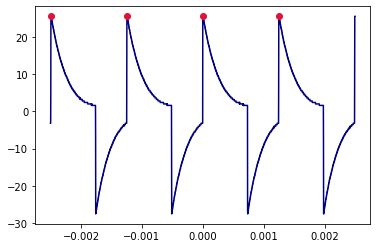

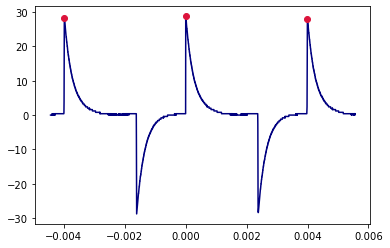

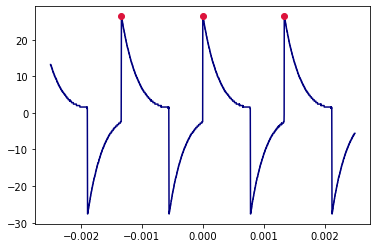

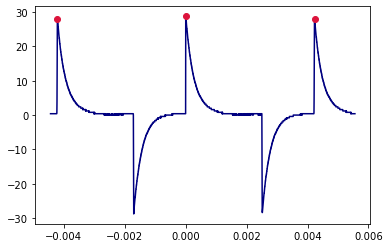

In [76]:
periods = []
for name in names:
    df = pd.read_csv(f'plots seke/special/barrido L/{name}.csv')
    
    pk_idx = pk(df.V_R,height=max(df.V_R)-5,distance=100)[0]
    
    periods.append(np.mean(np.diff(df.t[pk_idx])))
    
    plt.scatter(df.t[pk_idx],df.V_R[pk_idx],c='crimson',zorder=2)
    plt.plot(df.t,df.V_R,'navy',zorder=1)
    plt.show()
periods = np.array(periods)
freqs = 1/periods

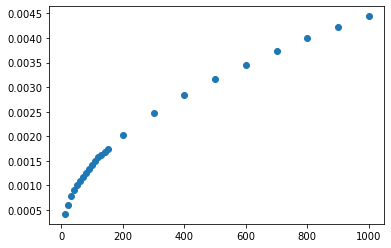

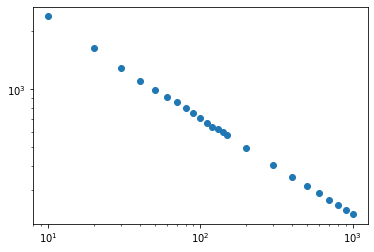

In [78]:
plt.scatter(names,periods)
plt.show()
plt.scatter(names,freqs)
plt.xscale('log')
plt.yscale('log')

0.9994194067964275

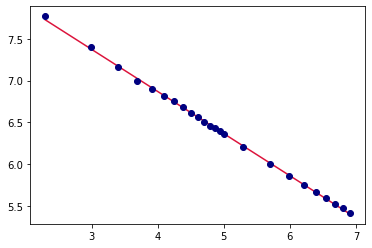

In [91]:
pars,cov = cf(lineal,np.log(names),np.log(freqs))
a,b = pars
x_adj = np.linspace(min(np.log(names)),max(np.log(names)))
y_adj = lineal(x_adj,*pars)
plt.scatter(np.log(names),np.log(freqs),c='navy',zorder=2)
plt.plot(x_adj,y_adj,'crimson',zorder=1)
r2(np.log(freqs),np.log(names),lineal,pars)

In [102]:
def omega(L,a,b):
    return np.exp(b)*L**a

def inductance(w,a,b):
    return np.exp(-b/a)*w**(1/a)

5.175945015992089


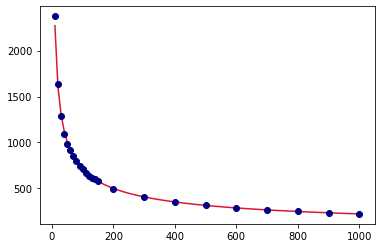

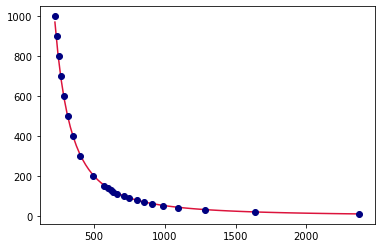

In [145]:
my_L = np.linspace(min(names),max(names),100)
my_w = np.linspace(min(freqs),max(freqs),100)

print(chi2_red(names,names*(0.01+np.random.normal(0.0025,0.0025,len(names))),freqs,inductance,pars))

plt.scatter(names,freqs,c='navy',zorder=2)
plt.plot(my_L,omega(my_L,a,b),'crimson',zorder=1)
plt.show()
plt.scatter(freqs,names,c='navy',zorder=2)
plt.plot(my_w,inductance(my_w,a,b),'crimson',zorder=1)
plt.show()

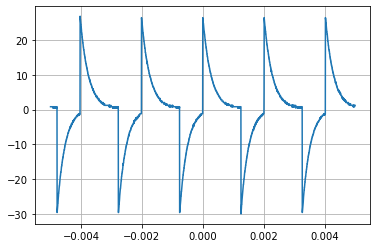

In [201]:
saver('hierro 4','1600',autoset=False)

In [159]:
def L_from_signal(name,folder,a,b):
    df = pd.read_csv(f'plots seke/special/{folder}/{name}.csv')
    
    pk_idx = pk(df.V_R,height=max(df.V_R)-5,distance=100)[0]
    
    period = np.mean(np.diff(df.t[pk_idx]))
    freq = 1/period
    L = inductance(freq,a,b)
    
    plt.scatter(df.t[pk_idx],df.V_R[pk_idx],c='crimson',zorder=2)
    plt.plot(df.t,df.V_R,'navy',zorder=1)
    plt.show()
    
    return L

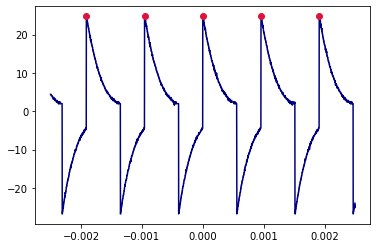

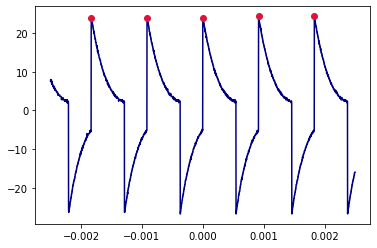

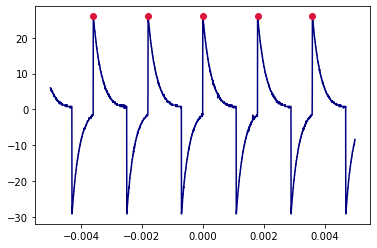

0.9168964205929324
3.4951481314470505


In [171]:
L_aire = L_from_signal('aire','1600',a,b)
L_al = L_from_signal('aluminio','1600',a,b)
L_fe = L_from_signal('hierro','1600',a,b)
print(L_al/L_aire)
print(L_fe/L_aire)

In [177]:
V_al = 4.5*1.3**2*np.pi
V_tot = 2.5**2*4.5
(V_al*L_al+(V_tot-V_al)*L_aire)/(V_tot)
L_aire

46.402257906567144